### Code

In [1]:
def iou_xyxy(a, b, eps=1e-12):
    #for a (two corner points to make box)
    #Top-left: (ax1, ay1)
    #Bottom-right: (ax2, ay2)
    
    #then
    #Top-right: (ax2, ay1)
    #Bottom-left: (ax1, ay2)
    ax1, ay1, ax2, ay2 = a
    bx1, by1, bx2, by2 = b

    # intersection
    inter_x1 = max(ax1, bx1)
    inter_y1 = max(ay1, by1)
    inter_x2 = min(ax2, bx2)
    inter_y2 = min(ay2, by2)
    iw = max(0.0, inter_x2 - inter_x1)
    ih = max(0.0, inter_y2 - inter_y1)
    inter = iw * ih

    # areas
    aw = max(0.0, ax2 - ax1)
    ah = max(0.0, ay2 - ay1)
    bw = max(0.0, bx2 - bx1)
    bh = max(0.0, by2 - by1)
    area_a = aw * ah
    area_b = bw * bh

    union = area_a + area_b - inter
    if union <= 0.0:   # covers degenerate boxes
        return 0.0
    return inter / (union + eps)

In [27]:
import matplotlib.pyplot as plt

def plot_pr_curve(points, ap=None, title="Precision–Recall Curve"):
    """
    points: list of (precision, recall) tuples
    ap: (optional) display AP in title
    """
    if not points:
        print("No points to plot.")
        return
    precisions, recalls = zip(*points)
    plt.figure(figsize=(6,4))
    plt.plot(recalls, precisions, marker='o', label="PR curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.ylim([0, 1.05])
    plt.xlim([0, 1.05])
    plt.grid(True)
    plt.title(f"{title}" + (f" (AP={ap:.3f})" if ap is not None else ""))
    plt.legend()
    plt.show()

In [30]:
import numpy as np

def compute_ap_from_points(points):
    if not points:
        return 0.0

    # Unzip points
    precisions, recalls = zip(*points)
    precisions = np.array(precisions)
    recalls = np.array(recalls)

    # Pad start and end
    mrec = np.concatenate(([0.0], recalls, [1.0]))
    mpre = np.concatenate(([0.0], precisions, [0.0]))

    # Make precision non-increasing (right-to-left max)
    for i in range(len(mpre) - 2, -1, -1):
        mpre[i] = max(mpre[i], mpre[i+1])

    # Only add area where recall increases
    idx = np.where(mrec[1:] != mrec[:-1])[0]
    ap = np.sum((mrec[idx + 1] - mrec[idx]) * mpre[idx + 1])

    return ap

In [10]:
def ap_score(preds, gts, iou_thresh=0.5):
    """
    preds: list of dicts {'imageid': ..., 'score': ..., 'box': ...}
    gts: dict gt_id: {'imageid': ..., 'bbox': ...}
    Returns: list of (precision, recall) tuples after each pred
    """
    tp = 0
    fp = 0
    tp_plus_fn = len(gts)
    gts_used = set()  # Store matched gt_id
    preds = sorted(preds, key=lambda d: d['score'], reverse=True)  # Sort by score descending
    points = []

    for p in preds:
        pimageid, pbox = p['imageid'], p['box']

        # Find GTs for this image that haven't been matched
        image_gts = [
            (gt_id, gt['bbox']) for gt_id, gt in gts.items()
            if gt['imageid'] == pimageid and gt_id not in gts_used
        ]

        # If no GTs left for image, it's a FP
        if not image_gts:
            fp += 1
            points.append((tp / (tp + fp), tp / tp_plus_fn))
            continue

        # Find best match by IoU
        best_gt_id, best_gt_box, best_iou = None, None, 0.0
        for gt_id, gt_box in image_gts:
            iou = iou_xyxy(pbox, gt_box)
            if iou > best_iou:
                best_iou = iou
                best_gt_id = gt_id
                best_gt_box = gt_box

        if best_iou >= iou_thresh:
            gts_used.add(best_gt_id)
            tp += 1
        else:
            fp += 1

        points.append((tp / (tp + fp), tp / tp_plus_fn))

    return points


### Tests

In [24]:
#iou test

#quadrant  
a = [0,0,1,1]
b = [0.5,0.5,1,1]
print(iou_xyxy(a,b))

#full
a = [0,0,1,1]
b = [0,0,1,1]
print(iou_xyxy(a,b))

#none
a = [0,0,1,1]
b = [1,1,2,2]
print(iou_xyxy(a,b))

0.24999999999974998
0.9999999999989999
0.0


In [25]:
#Test 1: Perfect detection, no FPs
gts = {
    1: {'imageid': 'img1', 'bbox': [0, 0, 10, 10]},
    2: {'imageid': 'img2', 'bbox': [0, 0, 10, 10]},
}
preds = [
    {'imageid': 'img1', 'score': 0.9, 'box': [0, 0, 10, 10]},
    {'imageid': 'img2', 'score': 0.8, 'box': [0, 0, 10, 10]},
]
print(ap_score(preds,gts))

#Test 2: One FP, one TP
gts = {
    1: {'imageid': 'img1', 'bbox': [0, 0, 10, 10]},
}
preds = [
    {'imageid': 'img1', 'score': 0.9, 'box': [0, 0, 10, 10]},
    {'imageid': 'img1', 'score': 0.5, 'box': [100, 100, 110, 110]},
]
print(ap_score(preds,gts))

#Test 3: All FPs
gts = {
    1: {'imageid': 'img1', 'bbox': [0, 0, 10, 10]},
}
preds = [
    {'imageid': 'img1', 'score': 0.8, 'box': [20, 20, 30, 30]},  # FP
    {'imageid': 'img1', 'score': 0.7, 'box': [50, 50, 60, 60]},  # FP
]
print(ap_score(preds,gts))

#Test 6: Wrong-image FP
# GT in img1, FP in img2
gts = {
    1: {'imageid': 'img1', 'bbox': [0, 0, 10, 10]},
}
preds = [
    {'imageid': 'img2', 'score': 0.7, 'box': [0, 0, 10, 10]},   # FP (wrong image)
]
print(ap_score(preds,gts))

[(1.0, 0.5), (1.0, 1.0)]
[(1.0, 1.0), (0.5, 1.0)]
[(0.0, 0.0), (0.0, 0.0)]
[(0.0, 0.0)]


### Full run with calculation, plot and mAP from slides

[(1.0, 0.3333333333333333), (1.0, 0.6666666666666666), (0.6666666666666666, 0.6666666666666666), (0.5, 0.6666666666666666), (0.6, 1.0)]


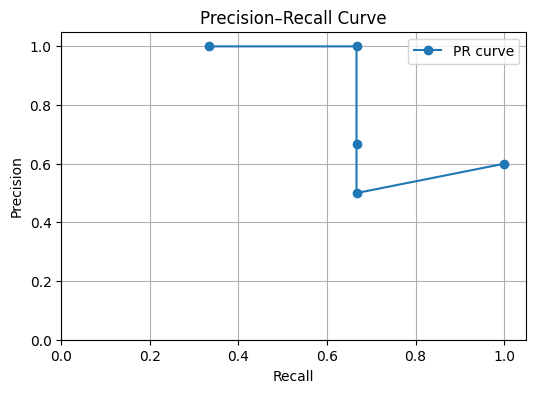

np.float64(0.8666666666666667)

In [33]:
# --- Ground truth ---
gts = {
    'gt1': {'imageid': 'img1', 'bbox': [10, 10, 30, 30]},    # GT1
    'gt2': {'imageid': 'img1', 'bbox': [60, 10, 80, 30]},    # GT2
    'gt3': {'imageid': 'img1', 'bbox': [110, 10, 130, 30]},  # GT3
}

# --- Predictions (already NMSed) ---
# pred1 only overlaps GT2, pred2 only overlaps GT1, pred5 only overlaps GT3.
preds = [
    {'imageid': 'img1', 'score': 0.99, 'box': [61, 11, 79, 29]},   # pred1 -> GT2  (TP)
    {'imageid': 'img1', 'score': 0.95, 'box': [12, 12, 28, 28]},   # pred2 -> GT1  (TP)
    {'imageid': 'img1', 'score': 0.90, 'box': [10, 50, 30, 70]},   # pred3 -> FP
    {'imageid': 'img1', 'score': 0.50, 'box': [60, 50, 80, 70]},   # pred4 -> FP
    {'imageid': 'img1', 'score': 0.10, 'box': [111, 11, 129, 29]}, # pred5 -> GT3  (TP)
]

# --- Run your evaluator ---
points = ap_score(preds, gts)   # make sure call order is (preds, gts)
print(points)

plot_pr_curve(points)
compute_ap_from_points(points)



### For the report

Mean Average Precision (mAP)
mAP comes from taking the mean of all AP the different classes across images which is a popular metric for object detection. AP for a class is important as it measures a high precision and high recall at the same time else the model could otherwise game each metrics. For instance, by only looking at recall, the model can make extremely many wild guesses where many of them will hit ground truths, while only looking at precision it can only consider the predictions the model is extremely confident about, but miss a lot of other ground truths.

The mAP algorithm for this project takes all the predictions from all the images with their confidence score and bounding boxes then sorts predictions based on confidence. This is favorable for AP to get as many true positives as we can in the beginning to keep a high precision and recall. When matching a prediction, the algorithm first finds all ground grund truth from the specific image, then IoU is calculated for all ground truth to find the ground truth that fits the best in case they overlap each other a lot. Lastly, in this pothole project, the only class is pothole meaning the outcome is only the AP for pothole across all images.
